In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# Our Model

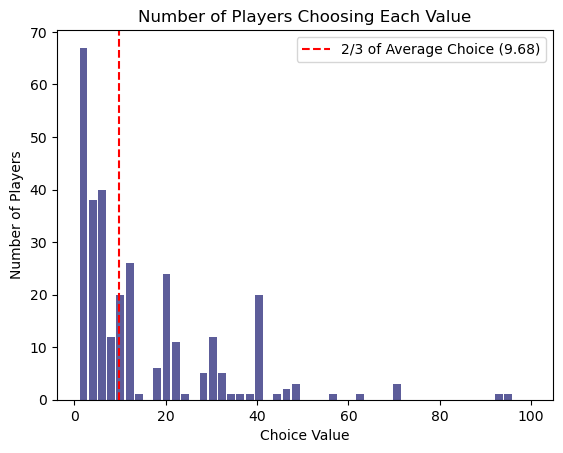

Maximum level of reasoning:  9
Average degree of the network:  27.95394736842105
Number of nodes in the network:  304


In [8]:
def belief_function(G, node):
    # Getting the outgoing neighbors (for directed graph)
    neighbors = list(G.successors(node))
    if not neighbors:
        # If no outgoing links, belief is a random number between 0 and node's level - 1
        return random.uniform(0, G.nodes[node]['level'] - 1)
    else:
        # The belief is the average level of the outgoing links
        return np.mean([G.nodes[neighbor]['level'] for neighbor in neighbors])


def choice_function(G, node):
    level = G.nodes[node]['level']
    # Randomly choose between a strategic choice and a completely random choice
    avg_belief = belief_function(G, node)
    # Strategic choice based on the average belief
    if level == 0:
        return random.uniform(1, 100)
    else:
        return ((2/3)**(avg_belief + 1)) * 60

def generate_directed_network(level_counts, p):
    G = nx.DiGraph()
    node_count = 0

    # Add nodes with their levels
    for level, count in enumerate(level_counts):
        for _ in range(count):
            G.add_node(node_count, level=level)
            node_count += 1

    # Connect nodes
    if p == 1:
        # In the case of p=1, connect each node in level k to all nodes in levels 0 to k-1
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for lower_level_node in G.nodes:
                if G.nodes[lower_level_node]['level'] < node_level:
                    G.add_edge(node, lower_level_node)
    elif p == 0:
        # In the case of p=0, return the graph with no edges
        pass
    else:
        # Calculate modified probability for other cases
        kappa = len(level_counts)
        p_hat = (p * (1 - p)) / (1 - p**(kappa - 1))

        # Connect nodes based on calculated probabilities
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for target_level in range(kappa):
                if node_level > target_level:
                    prob = (p_hat**(node_level - target_level)) * level_counts[target_level]
                    prob /= sum((p_hat**(node_level - k)) * level_counts[k] for k in range(node_level))
                    for target_node in G.nodes:
                        if G.nodes[target_node]['level'] == target_level and random.random() < prob:
                            G.add_edge(node, target_node)

    return G

def plot_choice_frequency(G):
    # Calculate choices for all nodes
    choices = [choice_function(G, node) for node in G.nodes]

    # Plotting the actual number of players choosing each value
    plt.hist(choices, bins=np.linspace(1, 100, 50), color='midnightblue', alpha=0.7, rwidth=0.85)
    plt.xlabel('Choice Value')
    plt.ylabel('Number of Players')
    plt.title('Number of Players Choosing Each Value')

    # Marking the 2/3 of the average of all choices with a dashed line
    avg_choice = np.mean(choices)
    plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
    plt.legend()

    plt.savefig('k-level synthetic experiments-Game choices.png', dpi=600)
    plt.show()

# Define the mean (λ) of the Poisson distribution
lambda_ = 30  # You can adjust this value as needed
# Define the number of levels
num_levels = 10  # Adjust this to match the number of levels you want
# Generate the level counts using the Poisson distribution
level_counts = np.random.poisson(lambda_, num_levels)


p = 0.5
network = generate_directed_network(level_counts, p)

# Plot the choice frequency for the generated network
plot_choice_frequency(network)
print("Maximum level of reasoning: ", len(level_counts)-1)
print("Average degree of the network: ", network.number_of_edges()/network.number_of_nodes())
print("Number of nodes in the network: ", network.number_of_nodes())

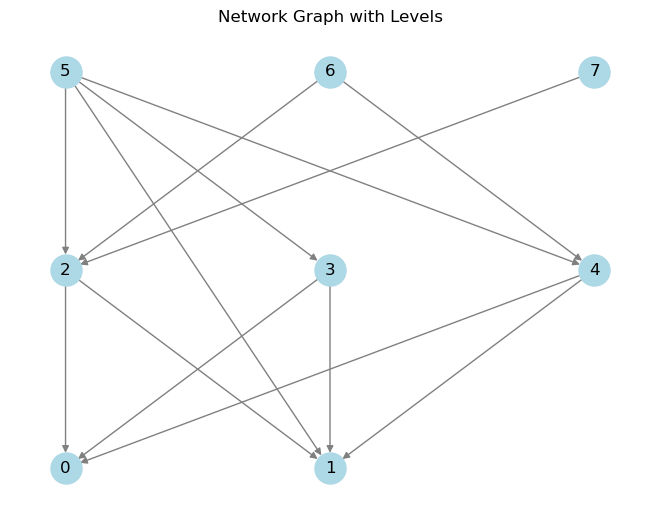

In [42]:
def plot_graph_with_levels(G):
    # Determine the number of levels
    levels = set(nx.get_node_attributes(G, 'level').values())
    max_level = max(levels) + 1

    # Create a position dictionary for each node
    pos = {}
    for level in range(max_level):
        nodes_at_level = [node for node, attr in G.nodes(data=True) if attr['level'] == level]
        level_pos = {node: (i, -level) for i, node in enumerate(nodes_at_level)}
        pos.update(level_pos)

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title('Network Graph with Levels')
    plt.gca().invert_yaxis()  # Invert y-axis to have lower levels at the bottom
    plt.savefig('k-level synthetic experiments-Example Network.png', dpi=600)
    plt.show()

level_counts_plot = [2, 3, 3]  # Number of players in each level
p_plot = 0.5
network_plot = generate_directed_network(level_counts_plot, p_plot)

# Plotting the graph
plot_graph_with_levels(network_plot)


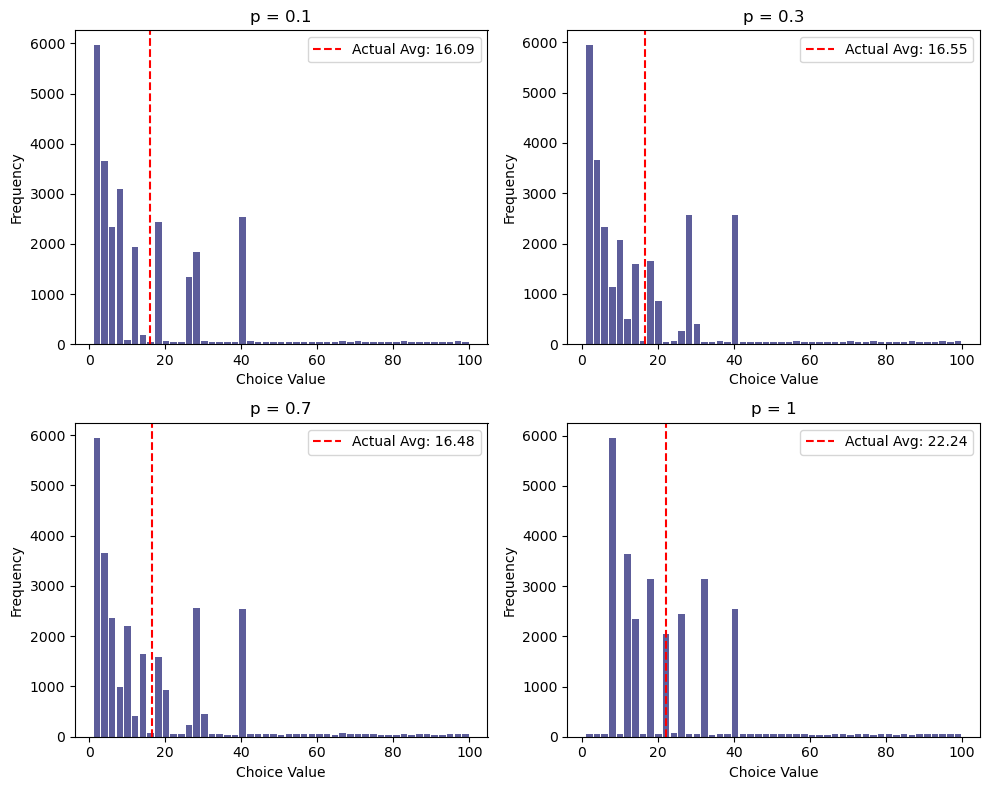

In [9]:
def average_choice_frequency_over_instances(level_counts, p, num_instances):
    all_choices = []

    for _ in range(num_instances):
        # Generate the network for each instance
        network = generate_directed_network(level_counts, p)

        # Calculate choices for all nodes in this instance
        choices = [choice_function(network, node) for node in network.nodes]
        all_choices.extend(choices)

    return all_choices

# Parameters
# Define the mean (λ) of the Poisson distribution
lambda_ = 30  # You can adjust this value as needed
# Define the number of levels
num_levels = 10  # Adjust this to match the number of levels you want
# Generate the level counts using the Poisson distribution
level_counts = np.random.poisson(lambda_, num_levels)

p_values = [0.1, 0.3, 0.7, 1]  # Different probabilities to be tested
num_instances = 100  # Number of instances to average over

fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 subplot grid
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for i, p in enumerate(p_values):
    # Calculate the average choice frequency over multiple instances
    average_choices = average_choice_frequency_over_instances(level_counts, p, num_instances)

    # Calculate the actual average of all choices
    actual_avg_choice = np.mean(average_choices)

    # Plot the average choice frequency on the ith subplot
    axs[i].hist(average_choices, bins=np.linspace(1, 100, 50), color='midnightblue', alpha=0.7, rwidth=0.85)
    axs[i].axvline(actual_avg_choice, color='red', linestyle='--', label=f'Actual Avg: {actual_avg_choice:.2f}')
    axs[i].set_xlabel('Choice Value')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'p = {p}')
    axs[i].legend()

plt.tight_layout()
# plt.savefig('k-level synthetic experiments-Average choice frequency.png', dpi=600)
plt.show()